## 1. Imports

In [5]:
import os
import json
import torch
import numpy as np
from pathlib import Path
from datasets import Dataset, concatenate_datasets, DatasetDict, Features, Value, Sequence
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

import optuna
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
from peft import LoraConfig, get_peft_model, TaskType

2025-05-30 11:39:06.141277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748605146.550960      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748605146.664719      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Data Paths

In [6]:
TRAIN_DIR = Path(r"/kaggle/input/nlp-augmentedset/aug_train")
DEV_DIR   = Path(r"/kaggle/input/nlp-augmentedset/aug_dev")
TEST_DIR  = Path(r"/kaggle/input/nlp-augmentedset/test")

assert TRAIN_DIR.exists(), f"Train directory not found: {TRAIN_DIR}"
assert DEV_DIR.exists(), f"Dev directory not found: {DEV_DIR}"
assert TEST_DIR.exists(), f"Test directory not found: {TEST_DIR}"

## 3. Load DocIE Data

In [7]:
def load_docie_docs(folder: Path, recursive: bool = False):
    """Load DocIE documents from JSON files."""
    docs = []
    pattern = "**/*.json" if recursive else "*.json"
    for file in folder.glob(pattern):
        data = json.loads(file.read_text(encoding="utf-8"))
        if isinstance(data, list):
            docs.extend(data)
        else:
            docs.append(data)
    return docs

train_docs = load_docie_docs(TRAIN_DIR)
dev_docs = load_docie_docs(DEV_DIR)
test_docs = load_docie_docs(TEST_DIR, recursive=True)

print(f"Loaded documents - Train: {len(train_docs)}, Dev: {len(dev_docs)}, Test: {len(test_docs)}")

Loaded documents - Train: 204, Dev: 88, Test: 248


## 4. Prepare Relation Extraction Data

In [8]:
def create_re_examples(docs, split_name):
    """Create relation extraction examples from DocIE documents."""
    examples = []
    
    for doc in docs:
        if not doc.get("triples") or not doc.get("entities"):
            continue
            
        text = doc.get("doc") or doc.get("document")
        if not text:
            continue
            
        entity_mentions = [ent["mentions"][0] for ent in doc["entities"] if ent.get("mentions")]
        
        # Create positive examples
        for triple in doc["triples"]:
            examples.append({
                "text": f"{triple['head']} [SEP] {triple['tail']} [SEP] {text}",
                "label": triple["relation"],
                "split": split_name
            })
            
        # Create negative examples
        positive_pairs = {(triple["head"], triple["tail"]) for triple in doc["triples"]}
        negative_count = 0
        max_attempts = len(doc["triples"]) * 10
        attempts = 0
        
        while negative_count < len(doc["triples"]) and attempts < max_attempts:
            attempts += 1
            if len(entity_mentions) < 2:
                break
                
            import random
            head, tail = random.sample(entity_mentions, 2)
            if (head, tail) not in positive_pairs and (tail, head) not in positive_pairs:
                examples.append({
                    "text": f"{head} [SEP] {tail} [SEP] {text}",
                    "label": "no_relation",
                    "split": split_name
                })
                negative_count += 1
    
    return examples

# Create examples
train_examples = create_re_examples(train_docs, "train")
dev_examples = create_re_examples(dev_docs, "dev")
test_examples = create_re_examples(test_docs, "test")

print(f"RE Examples - Train: {len(train_examples)}, Dev: {len(dev_examples)}, Test: {len(test_examples)}")

RE Examples - Train: 4888, Dev: 2398, Test: 0


## 5. Label Mapping

In [9]:
# Get all unique labels
all_labels = sorted(set(ex["label"] for ex in train_examples + dev_examples))
label2id = {label: i for i, label in enumerate(all_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Number of relation types: {len(all_labels)}")

# Analyze label distribution
label_counts = Counter(ex["label"] for ex in train_examples)
print("\nLabel distribution in training data:")
for label, count in label_counts.most_common(10):
    print(f"  {label}: {count}")

Number of relation types: 76

Label distribution in training data:
  no_relation: 2444
  HasPart: 328
  HasEffect: 268
  DiplomaticRelation: 180
  LocatedIn: 176
  InterestedIn: 152
  OwnerOf: 128
  NominatedFor: 100
  SaidToBeTheSameAs: 100
  PartOf: 72


## 6. Tokenization

In [10]:
model_name = "EleutherAI/gpt-neo-125M"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add padding token for GPT-Neo
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})

max_length = 512

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )

# Create datasets
train_dataset = Dataset.from_list(train_examples)
dev_dataset = Dataset.from_list(dev_examples)

# Tokenize
train_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text", "split"]
)

dev_dataset = dev_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text", "split"]
)

# Add labels
train_dataset = train_dataset.map(lambda x: {"labels": label2id[x["label"]]})
dev_dataset = dev_dataset.map(lambda x: {"labels": label2id[x["label"]]})

# Remove original label column
train_dataset = train_dataset.remove_columns(["label"])
dev_dataset = dev_dataset.remove_columns(["label"])

# Set format
train_dataset.set_format("torch")
dev_dataset.set_format("torch")

print(f"Tokenized datasets - Train: {len(train_dataset)}, Dev: {len(dev_dataset)}")

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

Map:   0%|          | 0/4888 [00:00<?, ? examples/s]

Map:   0%|          | 0/2398 [00:00<?, ? examples/s]

Map:   0%|          | 0/4888 [00:00<?, ? examples/s]

Map:   0%|          | 0/2398 [00:00<?, ? examples/s]

Tokenized datasets - Train: 4888, Dev: 2398


## 7. Evaluation Metrics

In [11]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )
    accuracy = accuracy_score(labels, predictions)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## 8. Baseline Model (3 epochs)

In [16]:
def train_baseline():
    """Train GPT-Neo baseline for relation extraction."""
    print("Training baseline model...")
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(all_labels),
        id2label=id2label,
        label2id=label2id
    )
    
    # Resize embeddings for padding token
    model.resize_token_embeddings(len(tokenizer))
    model.config.pad_token_id = tokenizer.pad_token_id
    
    training_args = TrainingArguments(
        output_dir="outputs/gpt-neo-re-baseline",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_steps=50,
        learning_rate=2e-5,
        warmup_steps=500,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        fp16=torch.cuda.is_available(),
        report_to="none",
        
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    metrics = trainer.evaluate()
    
    return trainer, metrics

baseline_trainer, baseline_metrics = train_baseline()
print(f"\nBaseline F1: {baseline_metrics['eval_f1']:.4f}")
print(f"Baseline Accuracy: {baseline_metrics['eval_accuracy']:.4f}")

Training baseline model...


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/3467633454.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.439700,2.924925,0.286656,0.492911,0.337119,0.492911
2,1.248500,3.216945,0.264134,0.495830,0.340262,0.495830
3,0.603000,3.176116,0.281865,0.481651,0.352823,0.481651


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Baseline F1: 0.3528
Baseline Accuracy: 0.4817


## 9. Hyperparameter Tuning - Full Fine-Tuning

In [11]:
def ft_objective(trial):
    """Optuna objective for full fine-tuning."""
    lr = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16])
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(all_labels),
        id2label=id2label,
        label2id=label2id
    )
    model.resize_token_embeddings(len(tokenizer))
    model.config.pad_token_id = tokenizer.pad_token_id
    
    args = TrainingArguments(
        output_dir=f"tmp/gpt-neo-re-ft-{trial.number}",
        max_steps=100,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        eval_strategy="steps",
        eval_steps=20,
        save_strategy="no",
        learning_rate=lr,
        fp16=torch.cuda.is_available(),
        logging_steps=20,
        report_to="none",
    )
    
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    return trainer.evaluate()["eval_f1"]

# Run optimization
study_ft = optuna.create_study(direction="maximize")
study_ft.optimize(ft_objective, n_trials=8)

print(f"Best FT params: {study_ft.best_params}")
print(f"Best FT F1: {study_ft.best_value:.4f}")

[I 2025-05-30 07:41:41,615] A new study created in memory with name: no-name-f1263397-589c-4f27-9c11-6acad772f407
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/3301683825.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.232200,3.697614,0.251698,0.463720,0.326291,0.463720
40,3.130200,3.400391,0.256349,0.394078,0.308444,0.394078
60,2.865700,3.197772,0.257396,0.469558,0.329419,0.469558
80,2.722600,3.142646,0.257786,0.456214,0.326720,0.456214
100,2.659700,3.141193,0.256909,0.450792,0.324751,0.450792


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 07:49:16,760] Trial 0 finished with value: 0.32475089956074776 and parameters: {'learning_rate': 2.718213731996222e-05, 'batch_size': 8}. Best is trial 0 with value: 0.32475089956074776.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/3301683825.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.347100,3.642421,0.254055,0.435780,0.319077,0.435780
40,3.269500,3.486077,0.250484,0.468307,0.326327,0.468307
60,3.231000,3.355156,0.254000,0.463303,0.326117,0.463303
80,3.075600,3.285646,0.253657,0.465388,0.326343,0.465388
100,2.884500,3.264959,0.297897,0.465805,0.328259,0.465805


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 07:57:04,887] Trial 1 finished with value: 0.32825857911654466 and parameters: {'learning_rate': 1.7789314534482568e-05, 'batch_size': 8}. Best is trial 1 with value: 0.32825857911654466.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/3301683825.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.616900,3.328562,0.261148,0.449958,0.323588,0.449958
40,2.832900,3.044296,0.270130,0.472894,0.337582,0.472894
60,2.428700,2.896502,0.343422,0.494162,0.334799,0.494162
80,2.297500,2.834202,0.283949,0.490409,0.338096,0.490409
100,2.234500,2.831627,0.274495,0.492911,0.333219,0.492911


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 08:06:19,157] Trial 2 finished with value: 0.3332189572895038 and parameters: {'learning_rate': 4.289287243180345e-05, 'batch_size': 16}. Best is trial 2 with value: 0.3332189572895038.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/3301683825.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.746600,3.415200,0.262125,0.445371,0.324268,0.445371
40,2.684200,3.097220,0.296706,0.488741,0.332239,0.488741
60,2.675600,2.977096,0.354982,0.495830,0.334449,0.495830
80,2.541700,2.915810,0.259955,0.484987,0.332886,0.484987
100,2.419300,2.901097,0.264683,0.488324,0.334194,0.488324


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 08:14:07,039] Trial 3 finished with value: 0.3341938880820841 and parameters: {'learning_rate': 4.904199543864886e-05, 'batch_size': 8}. Best is trial 3 with value: 0.3341938880820841.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/3301683825.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.178200,3.622427,0.249044,0.470809,0.325703,0.470809
40,3.368000,3.366399,0.254280,0.442869,0.321140,0.442869
60,2.910800,3.221748,0.260570,0.466639,0.327080,0.466639
80,2.655500,3.153152,0.265194,0.474979,0.336328,0.474979
100,2.673900,3.129953,0.266686,0.476230,0.337792,0.476230


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 08:23:21,855] Trial 4 finished with value: 0.33779166466164223 and parameters: {'learning_rate': 1.8235724987788577e-05, 'batch_size': 16}. Best is trial 4 with value: 0.33779166466164223.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/3301683825.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.730400,4.013316,0.256713,0.194746,0.219653,0.194746
40,3.723300,3.628083,0.254298,0.435780,0.319273,0.435780
60,3.341200,3.577728,0.250151,0.460801,0.324203,0.460801
80,3.190200,3.526107,0.253552,0.459133,0.324706,0.459133
100,3.487400,3.508117,0.253552,0.458716,0.324602,0.458716


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 08:30:30,355] Trial 5 finished with value: 0.32460173690730015 and parameters: {'learning_rate': 1.2793737556400751e-05, 'batch_size': 4}. Best is trial 4 with value: 0.33779166466164223.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/3301683825.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.490900,3.719385,0.260314,0.363219,0.300403,0.363219
40,3.574900,3.499633,0.252980,0.457882,0.323913,0.457882
60,3.181400,3.375957,0.253685,0.444120,0.320983,0.444120
80,2.889300,3.305497,0.254225,0.464137,0.326513,0.464137
100,2.932400,3.283396,0.341456,0.465805,0.327363,0.465805


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 08:39:45,002] Trial 6 finished with value: 0.3273630986696184 and parameters: {'learning_rate': 1.2600448474998054e-05, 'batch_size': 16}. Best is trial 4 with value: 0.33779166466164223.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/3301683825.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.119400,3.637821,0.249056,0.476230,0.327004,0.476230
40,3.070100,3.366903,0.258698,0.453294,0.324283,0.453294
60,3.020200,3.220876,0.250381,0.478732,0.328749,0.478732
80,2.863000,3.150512,0.264496,0.473311,0.332743,0.473311
100,2.684800,3.133572,0.273737,0.471643,0.338398,0.471643


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 08:47:32,608] Trial 7 finished with value: 0.33839777910918706 and parameters: {'learning_rate': 2.467262880195005e-05, 'batch_size': 8}. Best is trial 7 with value: 0.33839777910918706.


Best FT params: {'learning_rate': 2.467262880195005e-05, 'batch_size': 8}
Best FT F1: 0.3384


## 10. Hyperparameter Tuning - LoRA

In [13]:
def lora_objective(trial):
    """Optuna objective for LoRA fine-tuning."""
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    r = trial.suggest_categorical("r", [4, 8, 16])
    alpha = trial.suggest_categorical("alpha", [16, 32])
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16])
    
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=r,
        lora_alpha=alpha,
        lora_dropout=dropout,
        target_modules=["c_attn", "c_proj"],  # GPT-Neo specific
    )
    
    base_model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(all_labels),
        id2label=id2label,
        label2id=label2id
    )
    base_model.resize_token_embeddings(len(tokenizer))
    base_model.config.pad_token_id = tokenizer.pad_token_id
    
    model = get_peft_model(base_model, lora_config)
    
    args = TrainingArguments(
        output_dir=f"tmp/gpt-neo-re-lora-{trial.number}",
        max_steps=100,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        eval_strategy="steps",
        eval_steps=20,
        save_strategy="no",
        learning_rate=lr,
        fp16=torch.cuda.is_available(),
        logging_steps=20,
        report_to="none",
    )
    
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    return trainer.evaluate()["eval_f1"]

# Run optimization
study_lora = optuna.create_study(direction="maximize")
study_lora.optimize(lora_objective, n_trials=8)

print(f"Best LoRA params: {study_lora.best_params}")
print(f"Best LoRA F1: {study_lora.best_value:.4f}")

[I 2025-05-30 08:48:07,905] A new study created in memory with name: no-name-70d0cb57-538d-4c10-8911-1d4bbb7229bd
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/74789375.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensor

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.824000,3.386741,0.271399,0.338198,0.289908,0.338198
40,2.693700,3.216962,0.267140,0.429942,0.327713,0.429942
60,2.718000,3.185081,0.351332,0.480400,0.335047,0.480400
80,2.606300,3.131421,0.275725,0.456214,0.334647,0.456214
100,2.412200,3.102318,0.277296,0.457882,0.333865,0.457882


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 08:55:30,529] Trial 0 finished with value: 0.3338652593795139 and parameters: {'learning_rate': 0.0005495247793254406, 'r': 8, 'alpha': 32, 'dropout': 0.2649790520673084, 'batch_size': 8}. Best is trial 0 with value: 0.3338652593795139.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/74789375.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.434900,5.199249,0.210932,0.014178,0.019206,0.014178
40,5.019400,4.747695,0.303124,0.031276,0.048273,0.031276
60,4.552300,4.322066,0.300129,0.070475,0.107033,0.070475
80,4.010900,4.049629,0.298572,0.153461,0.193407,0.153461
100,4.020400,3.956906,0.293527,0.179316,0.211907,0.179316


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 09:02:27,499] Trial 1 finished with value: 0.21190738829388148 and parameters: {'learning_rate': 7.092012897485746e-05, 'r': 8, 'alpha': 16, 'dropout': 0.20374046911342464, 'batch_size': 4}. Best is trial 0 with value: 0.3338652593795139.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/74789375.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/loca

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.696800,3.301261,0.266233,0.413261,0.316360,0.413261
40,2.823200,3.200393,0.277170,0.445788,0.332803,0.445788
60,2.395300,3.100075,0.275913,0.460384,0.333653,0.460384
80,2.292900,3.065047,0.282581,0.460801,0.340512,0.460801
100,2.220400,3.057290,0.277315,0.463720,0.335461,0.463720


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 09:10:53,613] Trial 2 finished with value: 0.33546085674843473 and parameters: {'learning_rate': 0.0005785687500877714, 'r': 4, 'alpha': 16, 'dropout': 0.24071697680466897, 'batch_size': 16}. Best is trial 2 with value: 0.33546085674843473.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/74789375.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/lo

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.047500,3.431445,0.255929,0.460801,0.325942,0.460801
40,2.729800,3.214827,0.269512,0.429108,0.326953,0.429108
60,2.807000,3.175115,0.266124,0.450792,0.328590,0.450792
80,2.667200,3.151272,0.264948,0.431193,0.325302,0.431193
100,2.488400,3.137419,0.268939,0.438699,0.329309,0.438699


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 09:18:16,103] Trial 3 finished with value: 0.32930888954527415 and parameters: {'learning_rate': 0.000449627225192418, 'r': 8, 'alpha': 16, 'dropout': 0.040571844025126355, 'batch_size': 8}. Best is trial 2 with value: 0.33546085674843473.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/74789375.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/loc

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.156600,4.552033,0.313628,0.039199,0.060948,0.039199
40,3.899600,3.503607,0.257764,0.420767,0.316327,0.420767
60,3.251500,3.511268,0.248838,0.475813,0.326717,0.475813
80,3.009400,3.400662,0.252535,0.464554,0.325191,0.464554
100,3.279100,3.375305,0.253669,0.457048,0.324281,0.457048


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 09:25:13,828] Trial 4 finished with value: 0.3242806797240686 and parameters: {'learning_rate': 0.00012903007255386158, 'r': 4, 'alpha': 32, 'dropout': 0.1815007570533057, 'batch_size': 4}. Best is trial 2 with value: 0.33546085674843473.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/74789375.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/loca

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.918100,3.457789,0.261233,0.469975,0.326710,0.469975
40,2.900700,3.191489,0.266411,0.415763,0.322771,0.415763
60,2.471800,3.114481,0.267892,0.445788,0.329665,0.445788
80,2.359000,3.077873,0.283775,0.460801,0.338733,0.460801
100,2.301100,3.074096,0.279705,0.462469,0.337188,0.462469


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 09:33:40,777] Trial 5 finished with value: 0.33718829561183883 and parameters: {'learning_rate': 0.00043902157016477775, 'r': 4, 'alpha': 16, 'dropout': 0.08332129356555738, 'batch_size': 16}. Best is trial 5 with value: 0.33718829561183883.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/74789375.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/l

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.571300,5.368583,0.238555,0.012093,0.016007,0.012093
40,5.316900,5.105868,0.240999,0.015847,0.021643,0.015847
60,5.178800,4.851790,0.287849,0.026689,0.041038,0.026689
80,4.853600,4.681544,0.324010,0.035446,0.056517,0.035446
100,4.595400,4.619410,0.319793,0.037531,0.059343,0.037531


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 09:41:03,898] Trial 6 finished with value: 0.05934330361580167 and parameters: {'learning_rate': 3.363755225151843e-05, 'r': 4, 'alpha': 32, 'dropout': 0.04921286842875293, 'batch_size': 8}. Best is trial 5 with value: 0.33718829561183883.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/74789375.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/loc

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.637000,5.492134,0.230549,0.011676,0.015135,0.011676
40,5.557000,5.398161,0.227478,0.012510,0.015969,0.012510
60,5.599200,5.320100,0.251188,0.013761,0.017560,0.013761
80,5.424300,5.271939,0.236172,0.013761,0.017557,0.013761
100,5.254900,5.254430,0.211617,0.013761,0.017526,0.013761


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 09:48:26,656] Trial 7 finished with value: 0.017526020742548522 and parameters: {'learning_rate': 1.8884826281152702e-05, 'r': 4, 'alpha': 16, 'dropout': 0.1607390896991702, 'batch_size': 8}. Best is trial 5 with value: 0.33718829561183883.


Best LoRA params: {'learning_rate': 0.00043902157016477775, 'r': 4, 'alpha': 16, 'dropout': 0.08332129356555738, 'batch_size': 16}
Best LoRA F1: 0.3372


## 11. Hyperparameter Tuning - Partial Freezing

In [14]:
def freeze_objective(trial):
    """Optuna objective for partial freezing."""
    lr = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16])
    freeze_pct = trial.suggest_float("freeze_pct", 0.25, 0.75)
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(all_labels),
        id2label=id2label,
        label2id=label2id
    )
    model.resize_token_embeddings(len(tokenizer))
    model.config.pad_token_id = tokenizer.pad_token_id
    
    # Freeze lower layers
    total_layers = len([n for n, _ in model.named_parameters() if n.startswith("transformer.h.")])
    layers_to_freeze = int(total_layers * freeze_pct)
    
    for name, param in model.named_parameters():
        if name.startswith("transformer.h."):
            layer_num = int(name.split(".")[2])
            if layer_num < layers_to_freeze:
                param.requires_grad = False
    
    args = TrainingArguments(
        output_dir=f"tmp/gpt-neo-re-freeze-{trial.number}",
        max_steps=100,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        eval_strategy="steps",
        eval_steps=20,
        save_strategy="no",
        learning_rate=lr,
        fp16=torch.cuda.is_available(),
        logging_steps=20,
        report_to="none",
    )
    
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    return trainer.evaluate()["eval_f1"]

# Run optimization
study_freeze = optuna.create_study(direction="maximize")
study_freeze.optimize(freeze_objective, n_trials=8)

print(f"Best Freeze params: {study_freeze.best_params}")
print(f"Best Freeze F1: {study_freeze.best_value:.4f}")

[I 2025-05-30 09:49:24,891] A new study created in memory with name: no-name-b7cad64f-4c4c-454c-905c-406f87afbd79
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/2104240225.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.540300,5.379679,0.238583,0.012093,0.016013,0.012093
40,5.290300,5.217203,0.210785,0.013344,0.016964,0.013344
60,5.246800,5.102019,0.236881,0.016264,0.021993,0.016264
80,5.022300,5.038916,0.258887,0.017515,0.024480,0.017515
100,4.811500,5.016931,0.295764,0.020017,0.029295,0.020017


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 09:56:37,508] Trial 0 finished with value: 0.029295413090263005 and parameters: {'learning_rate': 3.0496021334728374e-05, 'batch_size': 8, 'freeze_pct': 0.7494639930228499}. Best is trial 0 with value: 0.029295413090263005.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/2104240225.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.623900,5.492770,0.298808,0.011676,0.015239,0.011676
40,5.525500,5.411210,0.226909,0.012093,0.015478,0.012093
60,5.573000,5.352933,0.239167,0.012927,0.016293,0.012927
80,5.405800,5.320802,0.250699,0.013344,0.017088,0.013344
100,5.241000,5.309570,0.250618,0.013344,0.017063,0.013344


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 10:03:49,947] Trial 1 finished with value: 0.017063297670036028 and parameters: {'learning_rate': 1.5047486593494805e-05, 'batch_size': 8, 'freeze_pct': 0.6134478712620085}. Best is trial 0 with value: 0.029295413090263005.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/2104240225.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.569200,5.395816,0.227664,0.012510,0.016021,0.012510
40,5.419900,5.243964,0.210081,0.012927,0.016454,0.012927
60,5.132300,5.139391,0.225589,0.014595,0.019572,0.014595
80,4.889500,5.073888,0.233123,0.015013,0.020337,0.015013
100,4.971400,5.051581,0.240382,0.015430,0.021133,0.015430


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 10:12:07,687] Trial 2 finished with value: 0.02113279349765483 and parameters: {'learning_rate': 2.3960600044692483e-05, 'batch_size': 16, 'freeze_pct': 0.4148388873734723}. Best is trial 0 with value: 0.029295413090263005.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/2104240225.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.458900,5.269616,0.222164,0.012927,0.016905,0.012927
40,5.064100,5.030199,0.278035,0.019600,0.028134,0.019600
60,4.937800,4.862018,0.288606,0.025438,0.038528,0.025438
80,4.662400,4.770736,0.288638,0.027940,0.042878,0.027940
100,4.413300,4.739151,0.291394,0.029191,0.045062,0.029191


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 10:19:20,454] Trial 3 finished with value: 0.04506217057743882 and parameters: {'learning_rate': 4.573948969033365e-05, 'batch_size': 8, 'freeze_pct': 0.7019650704348654}. Best is trial 3 with value: 0.04506217057743882.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/2104240225.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.497300,5.321597,0.250314,0.012510,0.016857,0.012510
40,5.170600,5.118277,0.235873,0.015847,0.021444,0.015847
60,5.082600,4.974785,0.284865,0.022519,0.033434,0.022519
80,4.830500,4.896509,0.296356,0.025021,0.037949,0.025021
100,4.598600,4.869318,0.292917,0.025438,0.038673,0.025438


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 10:26:33,330] Trial 4 finished with value: 0.038672877447831974 and parameters: {'learning_rate': 3.851381478939642e-05, 'batch_size': 8, 'freeze_pct': 0.2543291611845244}. Best is trial 3 with value: 0.04506217057743882.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/2104240225.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.485900,5.355409,0.238740,0.011676,0.015957,0.011676
40,5.261700,5.174768,0.210787,0.013761,0.018807,0.013761
60,5.071000,5.052107,0.282167,0.019183,0.027621,0.019183
80,4.843000,4.980114,0.283465,0.022102,0.032831,0.022102
100,4.893500,4.953307,0.300114,0.024187,0.036465,0.024187


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 10:33:19,603] Trial 5 finished with value: 0.03646463582388761 and parameters: {'learning_rate': 4.121408245899747e-05, 'batch_size': 4, 'freeze_pct': 0.7280325738566156}. Best is trial 3 with value: 0.04506217057743882.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/2104240225.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.644900,5.491927,0.254552,0.011259,0.014760,0.011259
40,5.616700,5.409361,0.227140,0.012510,0.015616,0.012510
60,5.431200,5.352139,0.239589,0.012927,0.016408,0.012927
80,5.243700,5.316144,0.251027,0.013344,0.017191,0.013344
100,5.355800,5.303869,0.251025,0.013344,0.017188,0.013344


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 10:41:35,908] Trial 6 finished with value: 0.017188254910011663 and parameters: {'learning_rate': 1.2853278607687636e-05, 'batch_size': 16, 'freeze_pct': 0.3398122150862259}. Best is trial 3 with value: 0.04506217057743882.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/2104240225.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.566500,5.470162,0.288075,0.010842,0.014490,0.010842
40,5.485900,5.371508,0.226022,0.011259,0.015115,0.011259
60,5.393800,5.304023,0.235246,0.012927,0.016918,0.012927
80,5.248600,5.264066,0.210815,0.013344,0.016978,0.013344
100,5.302300,5.249181,0.210815,0.013344,0.016978,0.013344


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-30 10:48:22,474] Trial 7 finished with value: 0.016978002083481606 and parameters: {'learning_rate': 2.2059395491566637e-05, 'batch_size': 4, 'freeze_pct': 0.39228928266480134}. Best is trial 3 with value: 0.04506217057743882.


Best Freeze params: {'learning_rate': 4.573948969033365e-05, 'batch_size': 8, 'freeze_pct': 0.7019650704348654}
Best Freeze F1: 0.0451


## 12. Final Training with Best Parameters

In [20]:
# Store results
results_summary = {
    "baseline": baseline_metrics,
    "full_ft": None,
    "lora": None,
    "partial_freeze": None
}

# Full Fine-Tuning with best params
print("\n" + "="*50)
print("FULL FINE-TUNING WITH BEST PARAMETERS")
print("="*50)

best_ft_params = study_ft.best_params
ft_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(all_labels),
    id2label=id2label,
    label2id=label2id
)
ft_model.resize_token_embeddings(len(tokenizer))
ft_model.config.pad_token_id = tokenizer.pad_token_id

ft_args = TrainingArguments(
    output_dir="outputs/gpt-neo-re-ft-final",
    max_steps=200,
    per_device_train_batch_size=best_ft_params["batch_size"],
    per_device_eval_batch_size=best_ft_params["batch_size"] * 2,
    eval_strategy="steps",
    eval_steps=20,
    save_strategy="no",
    learning_rate=best_ft_params["learning_rate"],
    fp16=torch.cuda.is_available(),
    report_to="none",
)

ft_trainer = Trainer(
    model=ft_model,
    args=ft_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

ft_trainer.train()
ft_metrics = ft_trainer.evaluate()
results_summary["full_ft"] = ft_metrics
print(f"Full FT F1: {ft_metrics['eval_f1']:.4f}")

# LoRA with best params
print("\n" + "="*50)
print("LoRA WITH BEST PARAMETERS")
print("="*50)

best_lora_params = study_lora.best_params
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=best_lora_params["r"],
    lora_alpha=best_lora_params["alpha"],
    lora_dropout=best_lora_params["dropout"],
    target_modules=["c_attn", "c_proj"],
)

base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(all_labels),
    id2label=id2label,
    label2id=label2id
)
base_model.resize_token_embeddings(len(tokenizer))
base_model.config.pad_token_id = tokenizer.pad_token_id

lora_model = get_peft_model(base_model, lora_config)
lora_model.print_trainable_parameters()

lora_args = TrainingArguments(
    output_dir="outputs/gpt-neo-re-lora-final",
    max_steps=200,
    per_device_train_batch_size=best_lora_params["batch_size"],
    per_device_eval_batch_size=best_lora_params["batch_size"] * 2,
    eval_strategy="steps",
    eval_steps=20,
    save_strategy="no",
    learning_rate=best_lora_params["learning_rate"],
    fp16=torch.cuda.is_available(),
    report_to="none",
    
)

lora_trainer = Trainer(
    model=lora_model,
    args=lora_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

lora_trainer.train()
lora_metrics = lora_trainer.evaluate()
results_summary["lora"] = lora_metrics
print(f"LoRA F1: {lora_metrics['eval_f1']:.4f}")

# Partial Freezing with best params
print("\n" + "="*50)
print("PARTIAL FREEZING WITH BEST PARAMETERS")
print("="*50)

best_freeze_params = study_freeze.best_params
freeze_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(all_labels),
    id2label=id2label,
    label2id=label2id
)
freeze_model.resize_token_embeddings(len(tokenizer))
freeze_model.config.pad_token_id = tokenizer.pad_token_id

# Apply freezing
total_layers = len([n for n, _ in freeze_model.named_parameters() if n.startswith("transformer.h.")])
layers_to_freeze = int(total_layers * best_freeze_params["freeze_pct"])

for name, param in freeze_model.named_parameters():
    if name.startswith("transformer.h."):
        layer_num = int(name.split(".")[2])
        if layer_num < layers_to_freeze:
            param.requires_grad = False

# Count trainable parameters
trainable_params = sum(p.numel() for p in freeze_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in freeze_model.parameters())
print(f"Trainable parameters: {trainable_params:,} / {total_params:,} ({trainable_params/total_params*100:.2f}%)")

freeze_args = TrainingArguments(
    output_dir="outputs/gpt-neo-re-freeze-final",
    max_steps=200,
    per_device_train_batch_size=best_freeze_params["batch_size"],
    per_device_eval_batch_size=best_freeze_params["batch_size"] * 2,
    eval_strategy="steps",
    eval_steps=20,
    save_strategy="no",
    learning_rate=best_freeze_params["learning_rate"],
    fp16=torch.cuda.is_available(),
    report_to="none",
)

freeze_trainer = Trainer(
    model=freeze_model,
    args=freeze_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

freeze_trainer.train()
freeze_metrics = freeze_trainer.evaluate()
results_summary["partial_freeze"] = freeze_metrics
print(f"Partial Freeze F1: {freeze_metrics['eval_f1']:.4f}")

\n==================================================
FULL FINE-TUNING WITH BEST PARAMETERS
FT Final Training: Effective BS: 8, Actual BS: 4, Grad Acc: 2


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/tmp/ipykernel_35/815101731.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ft_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.975800,3.863049,0.294008,0.471643,0.327699,0.471643
40,3.061500,3.363433,0.266824,0.449958,0.328421,0.449958
60,2.858700,3.293933,0.273011,0.486239,0.333411,0.486239
80,2.657600,3.140432,0.269625,0.467473,0.334335,0.467473
100,2.700200,3.098319,0.269354,0.487490,0.331820,0.487490
120,2.334500,3.037919,0.276307,0.490409,0.335045,0.490409
140,2.384800,3.008042,0.266998,0.494579,0.335055,0.494579
160,2.306800,3.005566,0.279509,0.495413,0.337821,0.495413
180,2.236000,3.004538,0.263473,0.495413,0.333691,0.495413
200,2.376800,2.995371,0.266208,0.493745,0.333787,0.493745


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

Full FT F1: 0.3338
\n==================================================
LoRA WITH BEST PARAMETERS
LoRA Final Training: Effective BS: 16, Actual BS: 4, Grad Acc: 4


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 242,688 || all params: 125,500,416 || trainable%: 0.1934


/tmp/ipykernel_35/815101731.py:126: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.844100,3.412768,0.275179,0.436614,0.321271,0.436614
40,2.663200,3.349540,0.281909,0.386155,0.312808,0.386155
60,2.429000,3.264125,0.260054,0.389074,0.309101,0.389074
80,2.282500,3.252667,0.262789,0.359466,0.299185,0.359466
100,2.206100,3.238790,0.257891,0.381151,0.305701,0.381151
120,2.087300,3.221984,0.254221,0.444537,0.322651,0.444537
140,2.125900,3.232649,0.266020,0.415763,0.318382,0.415763
160,2.045900,3.223322,0.255407,0.429108,0.320032,0.429108
180,1.933200,3.207082,0.260490,0.439533,0.323131,0.439533
200,1.852700,3.203838,0.254828,0.442035,0.322595,0.442035


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

LoRA F1: 0.3226
\n==================================================
PARTIAL FREEZING WITH BEST PARAMETERS
Freeze Final Training: Effective BS: 8, Actual BS: 4, Grad Acc: 2


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 40,230,912 / 125,257,728 (32.12%)


/tmp/ipykernel_35/815101731.py:204: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  freeze_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.991100,4.989683,0.268640,0.025021,0.039922,0.025021
40,4.463500,4.721925,0.268895,0.030859,0.048935,0.030859
60,4.139300,4.514584,0.282456,0.051710,0.082877,0.051710
80,3.757300,4.355665,0.282822,0.074229,0.113807,0.074229
100,3.798700,4.235009,0.255751,0.085488,0.124951,0.085488
120,3.452300,4.145079,0.255892,0.097164,0.137765,0.097164
140,3.305100,4.075097,0.262471,0.111343,0.153407,0.111343
160,3.143700,4.031488,0.269013,0.125938,0.168283,0.125938
180,3.189200,4.005671,0.269662,0.133028,0.175022,0.133028
200,3.247800,3.997261,0.266860,0.135113,0.176455,0.135113


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

Partial Freeze F1: 0.1765


## 13. Results Analysis and Visualization


GPT-NEO RELATION EXTRACTION RESULTS
        Method    F1  Precision  Recall  Accuracy
      Baseline 35.28      28.19   48.17     48.17
       Full Ft 33.38      26.62   49.37     49.37
          Lora 32.26      25.48   44.20     44.20
Partial Freeze 17.65      26.69   13.51     13.51


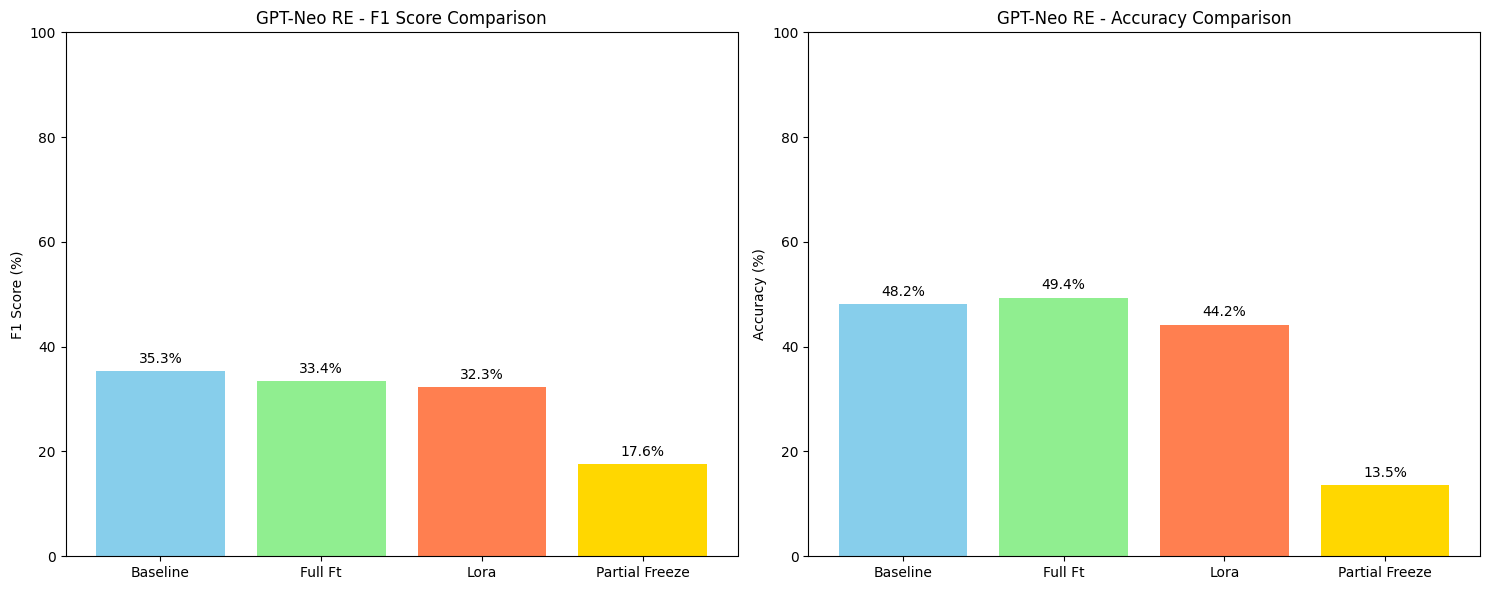


🏆 Best performing method: Baseline
   F1 Score: 35.28%
   Accuracy: 48.17%


In [21]:
# Create comparison DataFrame
comparison_data = []
for method, metrics in results_summary.items():
    comparison_data.append({
        "Method": method.replace("_", " ").title(),
        "F1": metrics["eval_f1"] * 100,
        "Precision": metrics["eval_precision"] * 100,
        "Recall": metrics["eval_recall"] * 100,
        "Accuracy": metrics["eval_accuracy"] * 100,
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(2)

print("\n" + "="*50)
print("GPT-NEO RELATION EXTRACTION RESULTS")
print("="*50)
print(comparison_df.to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# F1 Score comparison
methods = comparison_df["Method"].tolist()
f1_scores = comparison_df["F1"].tolist()

ax1.bar(methods, f1_scores, color=['skyblue', 'lightgreen', 'coral', 'gold'])
ax1.set_ylabel('F1 Score (%)')
ax1.set_title('GPT-Neo RE - F1 Score Comparison')
ax1.set_ylim(0, 100)

for i, v in enumerate(f1_scores):
    ax1.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

# Accuracy comparison
accuracies = comparison_df["Accuracy"].tolist()
ax2.bar(methods, accuracies, color=['skyblue', 'lightgreen', 'coral', 'gold'])
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('GPT-Neo RE - Accuracy Comparison')
ax2.set_ylim(0, 100)

for i, v in enumerate(accuracies):
    ax2.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('outputs/gpt_neo_re_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Best performing method
best_method_idx = comparison_df["F1"].idxmax()
best_method = comparison_df.iloc[best_method_idx]
print(f"\n🏆 Best performing method: {best_method['Method']}")
print(f"   F1 Score: {best_method['F1']:.2f}%")
print(f"   Accuracy: {best_method['Accuracy']:.2f}%")

## 14. Hyperparameter Analysis

In [24]:
print("\n" + "="*50)
print("HYPERPARAMETER ANALYSIS")
print("="*50)

print("\n📊 Full Fine-Tuning Best Parameters:")
for param, value in study_ft.best_params.items():
    print(f"  {param}: {value}")

print(f"\n📊 LoRA Best Parameters:")
for param, value in study_lora.best_params.items():
    print(f"  {param}: {value}")

print(f"\n📊 Partial Freeze Best Parameters:")
for param, value in study_freeze.best_params.items():
    print(f"  {param}: {value}")

# Save results
comparison_df.to_csv("outputs/gpt_neo_re_results.csv", index=False)
print("\n✅ Results saved to outputs/gpt_neo_re_results.csv")

# Save best model
best_trainer = ft_trainer if best_method['Method'] == 'Full Ft' else (
    lora_trainer if best_method['Method'] == 'Lora' else freeze_trainer
)
best_trainer.save_model("outputs/gpt-neo-re-best-model")
tokenizer.save_pretrained("outputs/gpt-neo-re-best-model")
print("💾 Best model saved to outputs/gpt-neo-re-best-model/")


HYPERPARAMETER ANALYSIS

📊 Full Fine-Tuning Best Parameters:
  learning_rate: 2.467262880195005e-05
  batch_size: 8

📊 LoRA Best Parameters:
  learning_rate: 0.00043902157016477775
  r: 4
  alpha: 16
  dropout: 0.08332129356555738
  batch_size: 16

📊 Partial Freeze Best Parameters:
  learning_rate: 4.573948969033365e-05
  batch_size: 8
  freeze_pct: 0.7019650704348654

✅ Results saved to outputs/gpt_neo_re_results.csv
💾 Best model saved to outputs/gpt-neo-re-best-model/


## 15. Final Summary

In [25]:
# Create summary report
summary = {
    "task": "Relation Extraction",
    "model": "GPT-Neo 125M",
    "dataset": "DocIE",
    "best_method": best_method['Method'],
    "best_f1": float(best_method['F1']),
    "best_accuracy": float(best_method['Accuracy']),
    "training_examples": len(train_dataset),
    "dev_examples": len(dev_dataset),
    "num_classes": len(all_labels),
    "hyperparameter_trials": 8,
    "fine_tuning_methods": ["Full Fine-Tuning", "LoRA", "Partial Freezing"]
}

with open("outputs/gpt_neo_re_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\n📊 Summary report saved to outputs/gpt_neo_re_summary.json")


📊 Summary report saved to outputs/gpt_neo_re_summary.json
